In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.optimizers import SGD
import seaborn as sns

In [22]:
dataset = pd.read_csv("/content/drive/MyDrive/Take2Ransomware/Dataset/ransomware_top_features.csv")
dataset = dataset. iloc[:, 1:]
print("Original dataset size: ",dataset.shape)

print(f"Number of unique values in the 'Label' column: {dataset['Label'].nunique()}")
print(dataset.head())

Original dataset size:  (392034, 21)
Number of unique values in the 'Label' column: 11
   Flow IAT Min  Flow IAT Max  Flow Duration  Flow Packets/s  Flow IAT Mean  \
0            24         49105         151054       92.682087    11619.53846   
1           349           349            349     5730.659026      349.00000   
2         37055         37055          37055       53.973823    37055.00000   
3            55         62243         178727       72.736632    14893.91667   
4           143           143            143    13986.013990      143.00000   

   Init_Win_bytes_forward  Bwd Packets/s  Fwd IAT Min  Fwd IAT Total  \
0                   65535      52.961193          111         101887   
1                    1594       0.000000          349            349   
2                    1548      26.986911            0              0   
3                   65535      39.165879          172         125550   
4                    1403       0.000000          143            143   

   Fw

In [23]:
def handle_dups_n_nans(dataSet):
    dataSet = dataSet.drop_duplicates()
    dataSet.replace([np.inf, -np.inf], np.nan, inplace=True)
    dataSet.dropna(inplace=True)

    return dataSet

def normalise_features(dataSet):
    numerical_features = dataSet.select_dtypes(include=['float64', 'int64']).columns

    mean = dataSet[numerical_features].mean()
    std = dataSet[numerical_features].std()

    dataSet[numerical_features] = (dataSet[numerical_features] - mean) / std

    return dataSet

def encode_categorical(dataSet):
    categorical_columns = dataSet.select_dtypes(exclude=['float64', 'int64']).columns

    for column in categorical_columns:
        unique_categories = dataSet[column].unique()
        category_to_label = {category: label for label, category in enumerate(unique_categories)}
        dataSet[column] = dataSet[column].map(category_to_label)

    return dataSet

def perform_preprocessing(dataSet):
    return encode_categorical(
        normalise_features(
            handle_dups_n_nans(
                dataSet
            )
        )
    )

def split_Xy(df):
    X = df.drop('Label', axis=1)
    y = df['Label']
    return X, y

dataset = perform_preprocessing(dataset)
dataset.head()

<ipython-input-23-d5f4b3eb62c4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataSet.replace([np.inf, -np.inf], np.nan, inplace=True)
<ipython-input-23-d5f4b3eb62c4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataSet.dropna(inplace=True)
<ipython-input-23-d5f4b3eb62c4>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataSet[numerical_features] = (dataSet[numerical_fea

,Flow IAT Min,Flow IAT Max,Flow Duration,Flow Packets/s,Flow IAT Mean,Init_Win_bytes_forward,Bwd Packets/s,Fwd IAT Min,Fwd IAT Total,Fwd IAT Max,...,Flow Bytes/s,Init_Win_bytes_backward,Flow IAT Std,Fwd IAT Std,Fwd Header Length,Packet Length Mean,Bwd Header Length,Packet Length Std,Packet Length Variance,Label
0,-0.233427,-0.506563,-0.486116,-0.123273,-0.373131,1.358152,-0.092980,-0.226033,-0.398410,-0.428704,...,-0.053549,-0.196132,-0.412020,-0.340375,0.002365,1.273769,0.002686,1.680427,1.179568,0
1,-0.233376,-0.509268,-0.492914,0.020656,-0.374724,-0.714951,-0.097642,-0.225999,-0.403777,-0.430836,...,-0.025470,-0.236632,-0.414426,-0.342495,0.002362,-0.543921,0.002679,-0.599438,-0.417864,0
2,-0.227619,-0.507232,-0.491258,-0.124261,-0.369536,-0.716443,-0.095266,-0.226050,-0.403796,-0.430861,...,-0.089591,-0.191785,-0.414426,-0.342495,0.002361,-0.517096,0.002680,-0.580266,-0.417137,0
3,-0.233422,-0.505835,-0.484868,-0.123782,-0.372668,1.358152,-0.094195,-0.226025,-0.397159,-0.425866,...,-0.081483,-0.196247,-0.411359,-0.337787,0.002365,-0.039047,0.002685,0.306071,-0.148229,0
4,-0.233408,-0.509280,-0.492923,0.231403,-0.374754,-0.721144,-0.097642,-0.226029,-0.403788,-0.430851,...,0.068088,-0.236632,-0.414426,-0.342495,0.002362,-0.543921,0.002679,-0.599438,-0.417864,0


In [24]:
train_ratio = 0.8
n_samples = dataset.shape[0]
indices = np.random.permutation(n_samples)

train_size = int(train_ratio * n_samples)
train_indices = indices[:train_size]
test_indices = indices[train_size:]

train_data = dataset.iloc[train_indices]
test_data = dataset.iloc[test_indices]

X_train, y_train = split_Xy(train_data)
X_test, y_test = split_Xy(test_data)

print("Train shape: ",X_train.shape," ",y_train.shape)
print("Test shape: ",X_test.shape," ",y_test.shape)

print(X_train.head())
print(y_train.head())


Train shape:  (306356, 20)   (306356,)
Test shape:  (76589, 20)   (76589,)
        Flow IAT Min  Flow IAT Max  Flow Duration  Flow Packets/s  \
6569       -0.233424     -0.405149      -0.407717       -0.125585   
59534      -0.233204     -0.509207      -0.492864       -0.090378   
50832      -0.227438      0.003151      -0.074537       -0.125631   
163863     -0.187867     -0.388036      -0.381236       -0.125608   
150393     -0.233431      0.261848       0.144980       -0.125615   

        Flow IAT Mean  Init_Win_bytes_forward  Bwd Packets/s  Fwd IAT Min  \
6569        -0.285761               -0.764622      -0.097502    -0.226050   
59534       -0.374569               -0.762903      -0.036861    -0.226050   
50832        0.280805               -0.629324      -0.097642    -0.220484   
163863      -0.199761               -0.766632      -0.097606     0.092342   
150393      -0.208184                1.358152      -0.097604    -0.225942   

        Fwd IAT Total  Fwd IAT Max  Fwd IAT Mea

In [29]:
# lets make our NN model layers
np.random.seed(42)
tf.random.set_seed(42)
num_features = 20
num_classes = 11
noOfEpochs=30
learningRate = 0.05

model = Sequential([
    Dense(512, activation='tanh', input_shape=(num_features,),kernel_initializer=HeNormal()),  # Input Layer
    Dense(256, activation='leaky_relu',kernel_initializer=HeNormal()),
    Dense(num_classes, activation='softmax')  # Output Layer
])

optimizer = SGD(learning_rate=learningRate)

model.compile(
    optimizer=optimizer,  # Adaptive Moment Estimation optimizer
    loss='sparse_categorical_crossentropy',  # Suitable for multi-class classification
    metrics=['accuracy']  # Tracking accuracy during training
)

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                      │ (None, 512)                 │          10,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 11)                  │           2,827 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 144,907 (566.04 KB)

 Trainable params: 144,907 (566.04 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
# Training the model
reduce_lr = ReduceLROnPlateau(
    monitor='loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)
history = model.fit(
    X_train, y_train,
    epochs=noOfEpochs,  # Number of training epochs
    batch_size=32,  # Mini-batch size
    verbose=1,  # Display training progress
    callbacks=[reduce_lr]
)

Epoch 1/30
9574/9574 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step - accuracy: 0.1466 - loss: 2.3001 - learning_rate: 0.0500
Epoch 2/30
9574/9574 ━━━━━━━━━━━━━━━━━━━━ 81s 4ms/step - accuracy: 0.1624 - loss: 2.2442 - learning_rate: 0.0500
Epoch 3/30
9574/9574 ━━━━━━━━━━━━━━━━━━━━ 81s 4ms/step - accuracy: 0.1659 - loss: 2.2334 - learning_rate: 0.0500
Epoch 4/30
9574/9574 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - accuracy: 0.1682 - loss: 2.2268 - learning_rate: 0.0500
Epoch 5/30
9574/9574 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - accuracy: 0.1697 - loss: 2.2219 - learning_rate: 0.0500
Epoch 6/30
9574/9574 ━━━━━━━━━━━━━━━━━━━━ 39s 4ms/step - accuracy: 0.1710 - loss: 2.2180 - learning_rate: 0.0500
Epoch 7/30
9574/9574 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step - accuracy: 0.1723 - loss: 2.2148 - learning_rate: 0.0500
Epoch 8/30
9574/9574 ━━━━━━━━━━━━━━━━━━━━ 43s 4ms/step - accuracy: 0.1733 - loss: 2.2119 - learning_rate: 0.0500
Epoch 9/30
9574/9574 ━━━━━━━━━━━━━━━━━━━━ 79s 4ms/step - accuracy: 0.1735 - loss: 2.2093 - learn

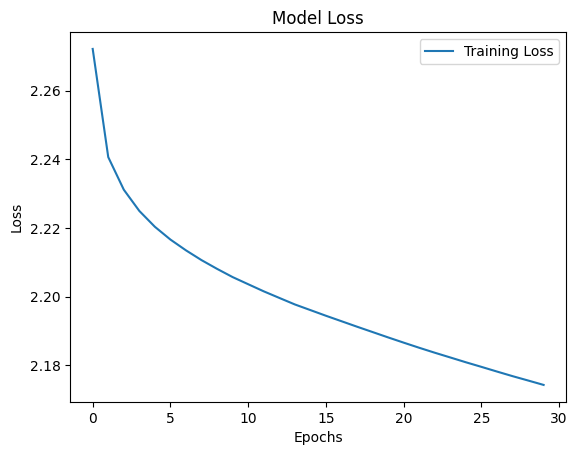

In [31]:
plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

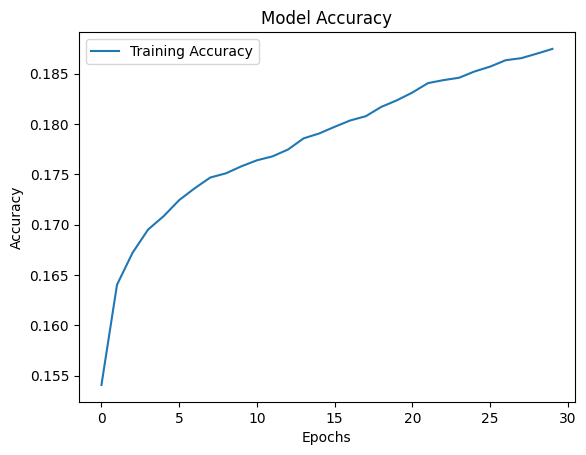

In [32]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()